# 대구 CCTV 데이터 구조 및 기초 탐색 (EDA)

이 노트북에서는 **대구 공공데이터 시각화 프로젝트**에서 사용되는  
`대구 CCTV 정보.csv` 파일에 대해 다음 내용을 실습합니다.

1. `df.head(10)` 및 기본 요약 정보  
   - 전체 행 수  
   - 전체 컬럼 수  
   - 평균 결측값 비율(%)  
2. `df.info()`를 통한 컬럼 구조·타입 확인  
3. **수치형 / 범주형 컬럼 자동 분리**  
4. 위도·경도 정보를 이용한 **지도 시각화 (Folium + MarkerCluster)**  
5. 모든 **수치형 컬럼에 대한 히스토그램 + 박스플롯**  
6. 모든 **범주형 컬럼에 대한 bar chart(히스토그램)**

이 노트북은 이후 Streamlit 시각화 대시보드에 들어갈 CCTV 탭 구성을  
Colab에서 미리 검증하는 단계입니다.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,851 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
matplotlibrc 경로: /usr/local/lib/p

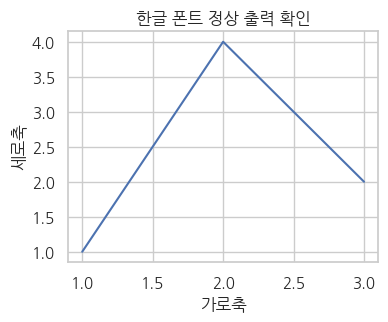

In [ ]:
# ==========================================
# 1. 한글 출력을 위한 기초 셀
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

root = mpl.matplotlib_fname().replace("matplotlibrc", "")
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()

In [ ]:
# ==========================================
# 2. 기본 라이브러리 임포트
# ==========================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import MarkerCluster

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지


## 3. 대구 CCTV 데이터 로드

`대구 CCTV 정보.csv`는 Colab에서 **직접 업로드**하는 방식으로 불러옵니다.

- 실습 참여자가 각자 로컬에 있는 CSV를 업로드  
- 또는 구글 드라이브에 올려두고 경로를 바꾸어 사용할 수도 있습니다.


In [ ]:
# ==========================================
# 3. 대구 CCTV 정보.csv 업로드 및 로드
# ==========================================
from google.colab import files

print("대구 CCTV 정보.csv 파일을 선택해서 업로드 해주세요.")
uploaded = files.upload()

print("업로드된 파일 목록:", list(uploaded.keys()))
file_name = list(uploaded.keys())[0]
print("사용할 파일 이름:", file_name)

def read_csv_safe(path, encodings=["utf-8", "utf-8-sig", "cp949"]):
    """
    여러 인코딩을 시도하면서 CSV 파일을 안전하게 읽기 위한 함수.
    """
    last_error = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_error = e
            print(f"[경고] 인코딩 {enc} 로 읽기 실패: {e}")
            continue
    raise ValueError(f"CSV를 어떤 인코딩으로도 읽을 수 없습니다. 마지막 에러: {last_error}")

df = read_csv_safe(file_name)

print("데이터 로딩 완료!")
print("데이터 형태 (행, 열):", df.shape)


대구 CCTV 정보.csv 파일을 선택해서 업로드 해주세요.


Saving 대구 CCTV 정보.csv to 대구 CCTV 정보.csv
업로드된 파일 목록: ['대구 CCTV 정보.csv']
사용할 파일 이름: 대구 CCTV 정보.csv
[경고] 인코딩 utf-8 로 읽기 실패: 'utf-8' codec can't decode byte 0xb9 in position 0: invalid start byte
[경고] 인코딩 utf-8-sig 로 읽기 실패: 'utf-8' codec can't decode byte 0xb9 in position 0: invalid start byte
데이터 로딩 완료!
데이터 형태 (행, 열): (1065, 18)


In [ ]:
# ==========================================
# 4. 데이터 상위 10행 및 기본 요약 정보
# ==========================================

print("=== 대구 CCTV 데이터 상위 10행 (head(10)) ===")
display(df.head(10))

print("\n=== 대구 CCTV 데이터 기본 요약 ===")
total_rows = df.shape[0]
total_cols = df.shape[1]
missing_ratio = df.isnull().mean().mean() * 100

print(f"전체 행 수: {total_rows:,}")
print(f"전체 컬럼 수: {total_cols:,}")
print(f"평균 결측값 비율: {missing_ratio:.2f}%")

# 기대 예시:
# 전체 행 수: 1,065
# 전체 컬럼 수: 18
# 평균 결측값 비율: 16.50% (근사치)


=== 대구 CCTV 데이터 상위 10행 (head(10)) ===


,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0
5,주차17,대구광역시,남구,시도,NaN,중앙대로,3,대구광역시 남구 중앙대로 29길 21,대구광역시 남구 대명동 52-2,35.845974,128.589108,영대병원 정문 앞,4,0,NaN,NaN,99.0,2017.0
6,주차18,대구광역시,남구,시도,NaN,중앙대로,3,대구광역시 남구 중앙대로 236,대구광역시 남구 대명동 2005-12,35.854194,128.590919,남구보건소,4,0,NaN,NaN,99.0,2017.0
7,주차19,대구광역시,남구,시도,NaN,이천로,3,대구광역시 남구 이천로19길 81,대구광역시 남구 대명동 2-34,35.851079,128.594128,동서프라임 삼거리,4,0,NaN,NaN,99.0,2017.0
8,주차20,대구광역시,남구,시도,NaN,앞산순환로,3,대구광역시 남구 앞산순환로 574-87,대구광역시 남구 대명동 산227-5,35.828958,128.589035,앞산공원관리사무소,4,0,NaN,NaN,1.0,2017.0
9,주차21,대구광역시,남구,시도,NaN,용두길,3,대구광역시 남구 용두길 31,대구광역시 남구 봉덕동 1206-21,35.833648,128.604624,고산골 입구,4,0,NaN,NaN,99.0,2017.0



=== 대구 CCTV 데이터 기본 요약 ===
전체 행 수: 1,065
전체 컬럼 수: 18
평균 결측값 비율: 16.49%


In [ ]:
# ==========================================
# 5. df.info()로 전체 스키마 확인
# ==========================================
print("=== 대구 CCTV 데이터 info() ===")
df.info()


=== 대구 CCTV 데이터 info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1063 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-n

## 6. 수치형 / 범주형 컬럼 분리

CCTV 데이터에서도 **수치형 / 범주형 컬럼을 자동으로 분리**합니다.

- 수치형: 히스토그램 + 박스플롯  
- 범주형: 값의 빈도수를 보는 bar chart  

이 구분은 이후 Streamlit 대시보드에서도 동일하게 사용될 예정입니다.


In [ ]:
# ==========================================
# 6. 수치형 / 범주형 컬럼 분리
# ==========================================

numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("=== 수치형 컬럼 목록 ===")
print(numeric_cols)

print("\n=== 범주형 컬럼 목록 ===")
print(categorical_cols)


=== 수치형 컬럼 목록 ===
['도로노선방향', '위도', '경도', '단속구분', '제한속도', '단속구간위치구분', '과속단속구간길이', '보호구역구분', '설치연도']

=== 범주형 컬럼 목록 ===
['무인교통단속카메라관리번호', '시도명', '시군구명', '도로종류', '도로노선번호', '도로노선명', '소재지도로명주소', '소재지지번주소', '설치장소']


## 7. 위도·경도 기반 지도 시각화 (Folium + MarkerCluster)

CCTV 위치를 지도 위에 시각화하기 위해  
**Folium** 라이브러리와 **MarkerCluster** 플러그인을 사용합니다.

- Folium: Python에서 Leaflet.js 기반 지도를 그려주는 라이브러리  
- MarkerCluster: 많은 포인트를 클러스터 형태로 묶어 표시하는 기능  

### 절차
1. CCTV 데이터에서 **위도(latitude), 경도(longitude)** 컬럼 이름을 확인  
2. 해당 컬럼을 사용하여 Folium 지도 객체 생성  
3. MarkerCluster에 CCTV 위치를 반복문으로 추가  
4. 클러스터된 지도를 출력  


In [ ]:
# ==========================================
# 7. 위도/경도 컬럼 자동 감지 및 Folium 지도 표시
# ==========================================

# 1) 위도/경도 컬럼 후보 정의
lat_candidates = ["위도", "lat", "LAT", "y", "Y좌표"]
lng_candidates = ["경도", "lon", "LONG", "lng", "x", "X좌표"]

lat_col = None
lng_col = None

for c in df.columns:
    if c in lat_candidates:
        lat_col = c
    if c in lng_candidates:
        lng_col = c

print("탐지된 위도 컬럼:", lat_col)
print("탐지된 경도 컬럼:", lng_col)

if (lat_col is None) or (lng_col is None):
    raise ValueError("위도/경도 컬럼명을 찾지 못했습니다. lat_candidates, lng_candidates 리스트를 수정해주세요.")

# 2) 유효한 좌표만 선택
geo_df = df[[lat_col, lng_col]].dropna()

print("좌표 정보가 있는 행 수:", len(geo_df))

# 3) 지도 중심 좌표 계산 (평균값 사용)
center_lat = geo_df[lat_col].mean()
center_lng = geo_df[lng_col].mean()

# 4) Folium 지도 생성
m = folium.Map(location=[center_lat, center_lng], zoom_start=11)

# 5) MarkerCluster로 CCTV 포인트 추가
marker_cluster = MarkerCluster().add_to(m)

for _, row in geo_df.iterrows():
    folium.Marker(
        location=[row[lat_col], row[lng_col]],
        icon=folium.Icon(color="red", icon="camera", prefix="fa")
    ).add_to(marker_cluster)

# 6) 지도 출력
m


탐지된 위도 컬럼: 위도
탐지된 경도 컬럼: 경도
좌표 정보가 있는 행 수: 1065


## 8. 수치형 변수에 대한 히스토그램 & 박스플롯

각 수치형 컬럼에 대해

- **히스토그램**: 분포를 전체적으로 확인  
- **박스플롯(Box Plot)**: 중앙값, IQR, 이상치 여부 등을 확인  

두 가지 그래프를 모두 그려 보며  
CCTV 데이터의 수치 특성이 어떤 형태인지 파악합니다.


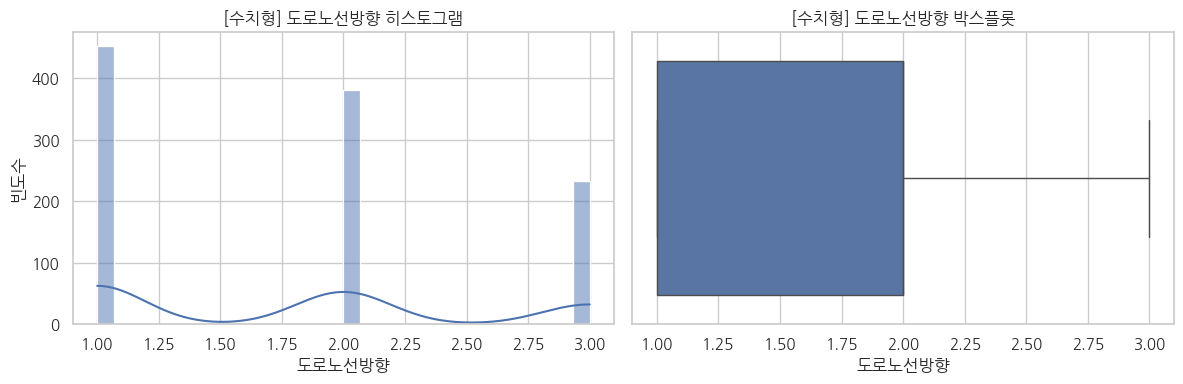

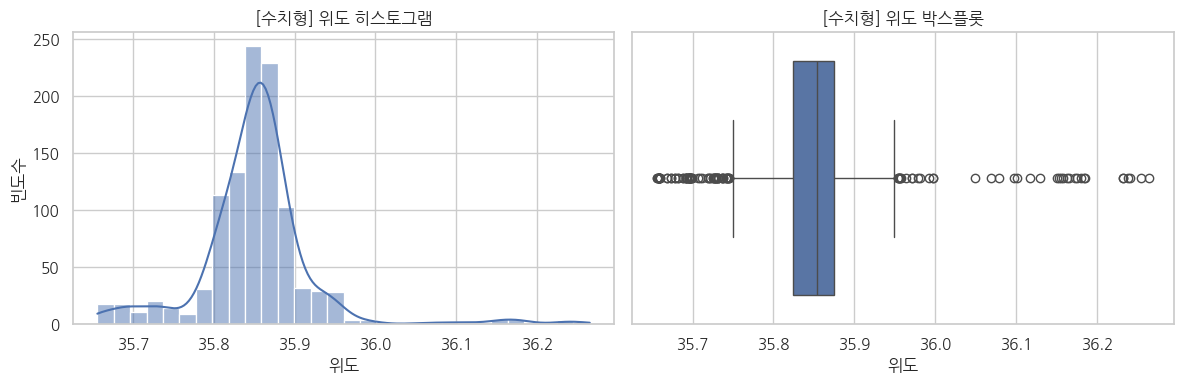

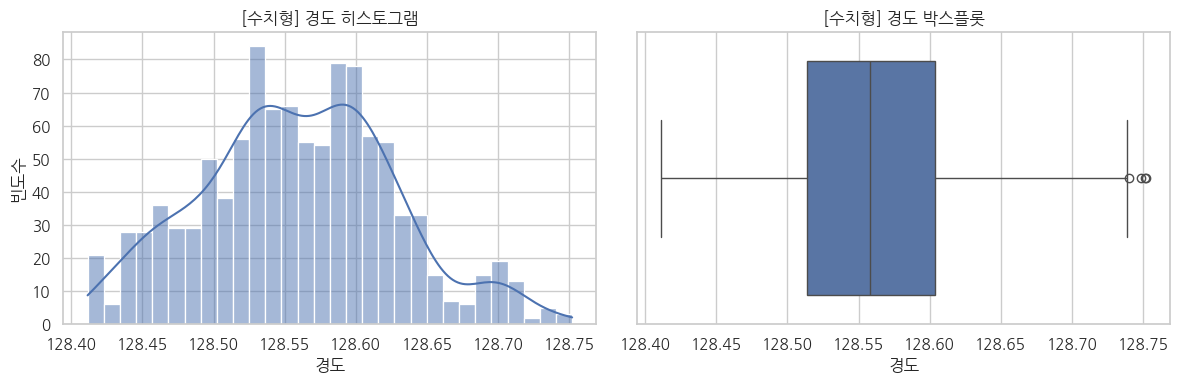

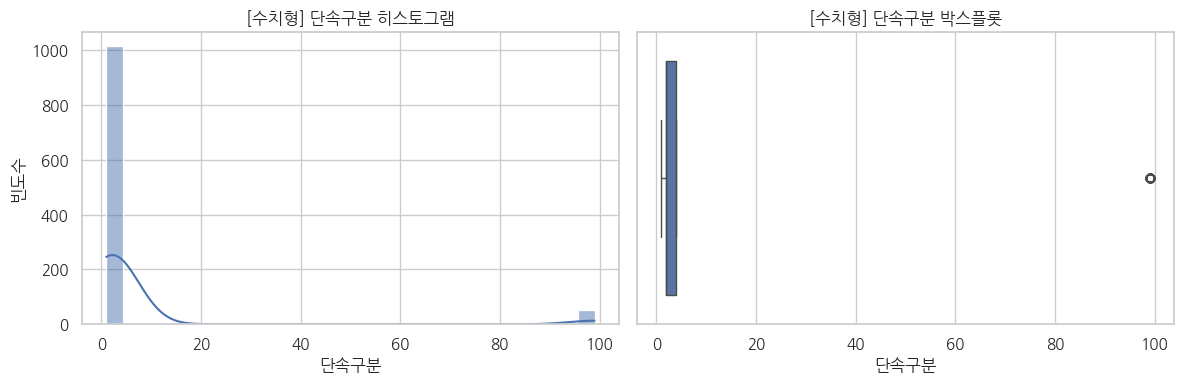

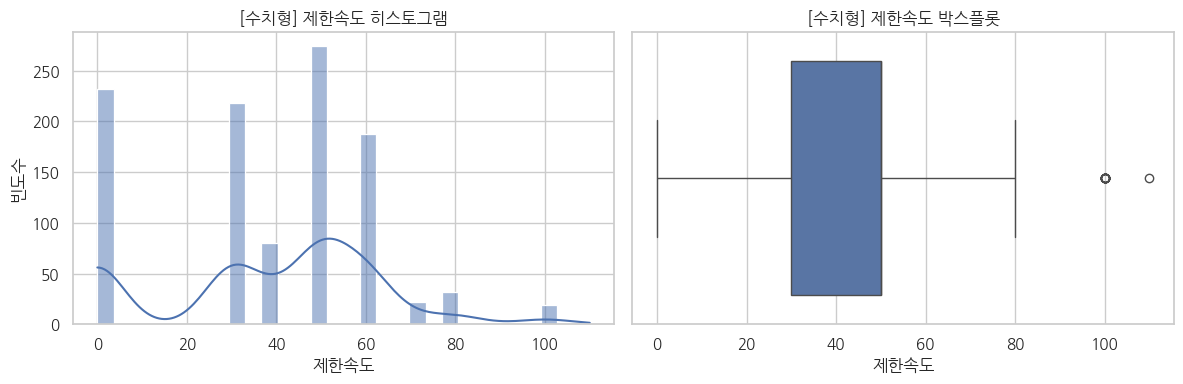

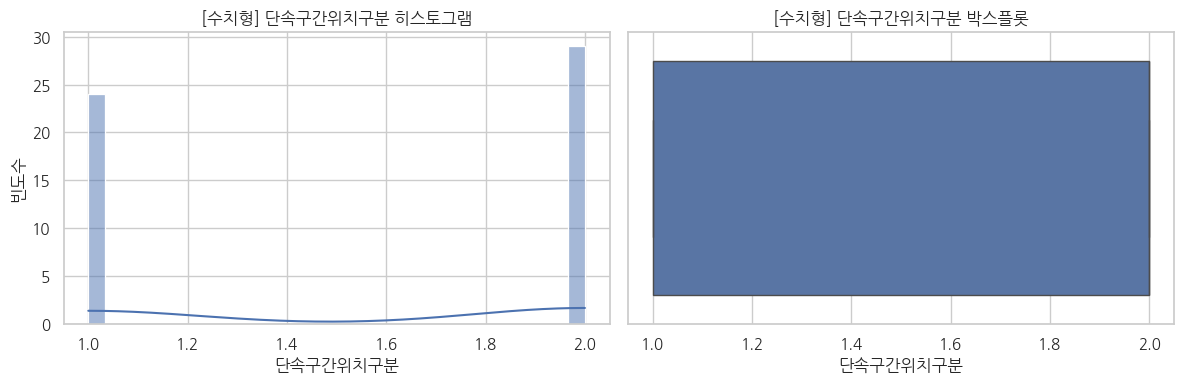

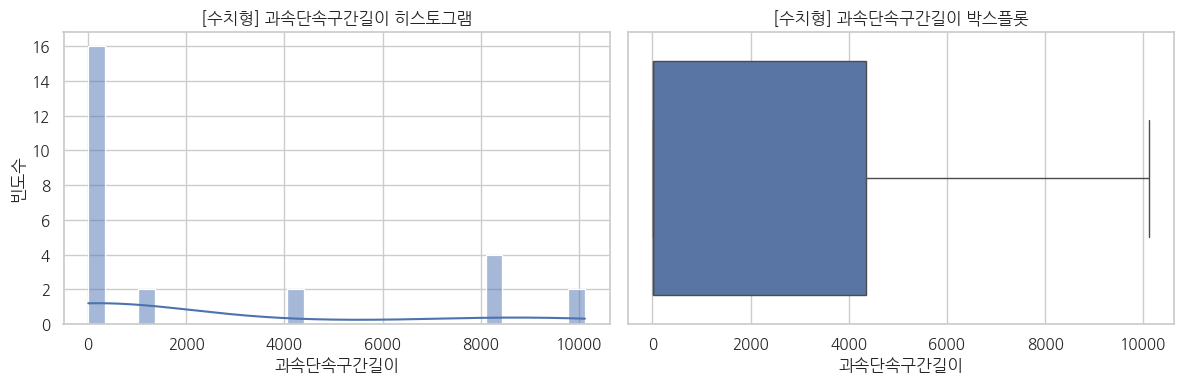

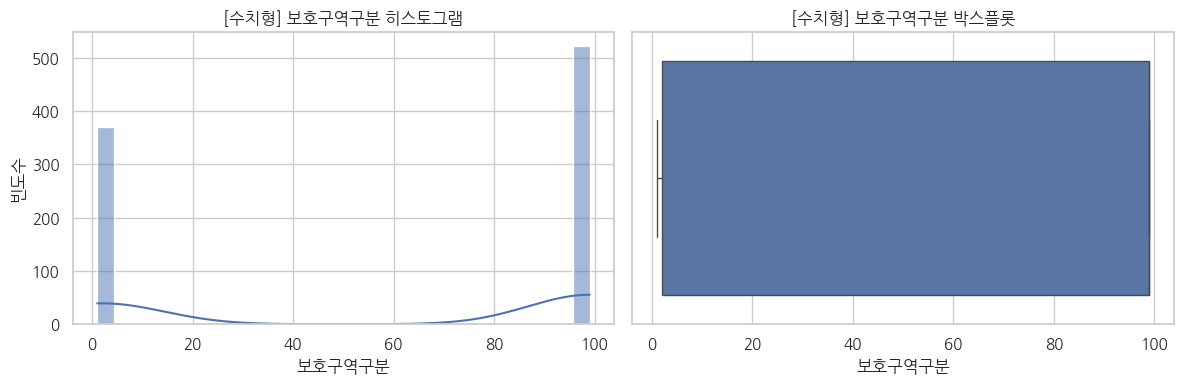

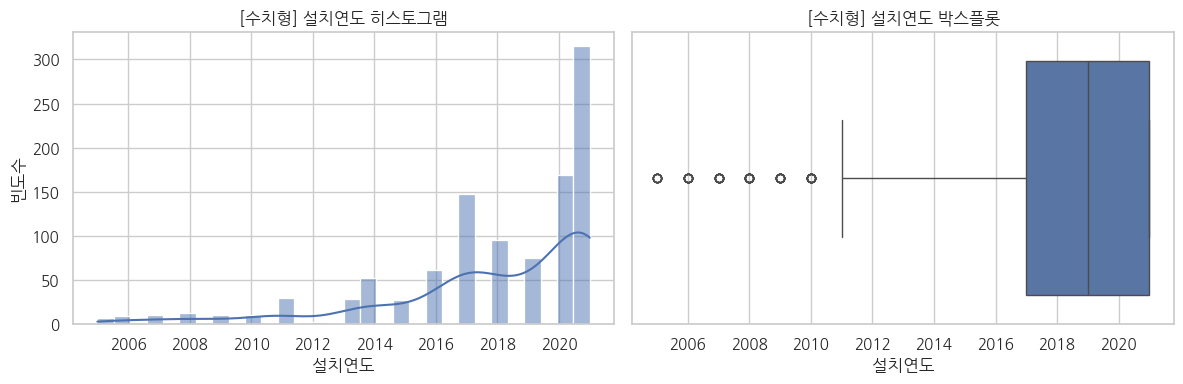

In [ ]:
# ==========================================
# 8. 모든 수치형 컬럼 히스토그램 + 박스플롯
# ==========================================

if len(numeric_cols) == 0:
    print("수치형 컬럼이 없어 시각화를 수행할 수 없습니다.")
else:
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # 히스토그램
        sns.histplot(data=df, x=col, kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f"[수치형] {col} 히스토그램")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("빈도수")

        # 박스플롯
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f"[수치형] {col} 박스플롯")
        axes[1].set_xlabel(col)

        plt.tight_layout()
        plt.show()


## 9. 범주형 변수에 대한 빈도수 bar chart

범주형 컬럼은 값이 얼마나 자주 등장하는지가 중요합니다.

- 예: CCTV 설치 용도, 설치 위치 타입, 관리 기관 등  
- 각 컬럼별로 **상위 N개 카테고리**만 잘라서 bar chart로 표시합니다.


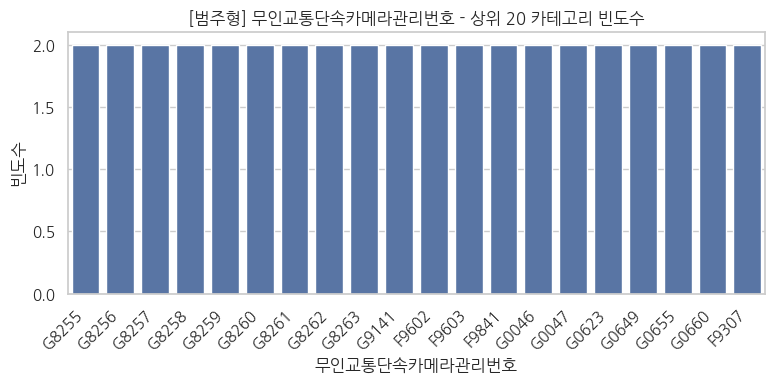

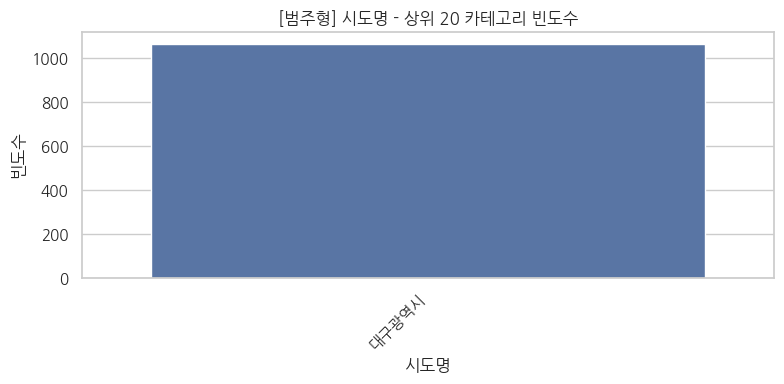

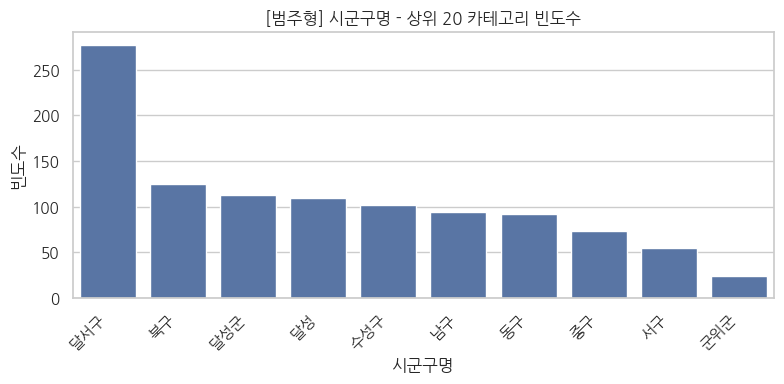

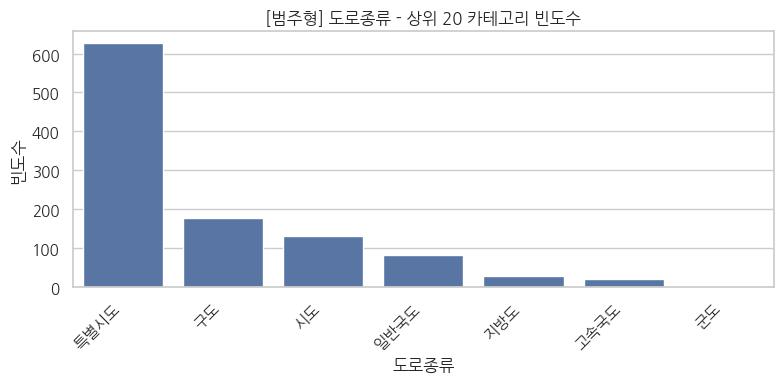

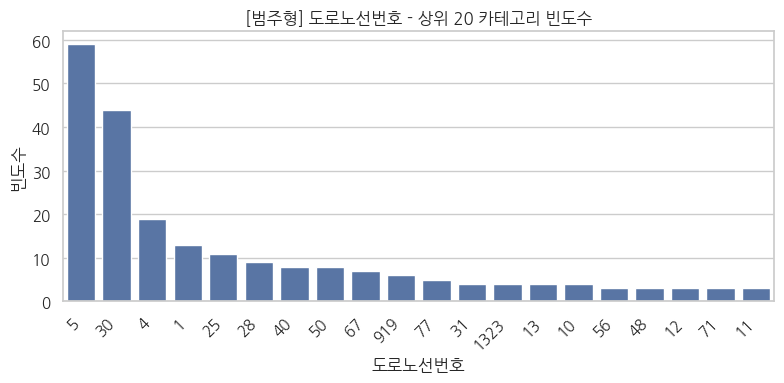

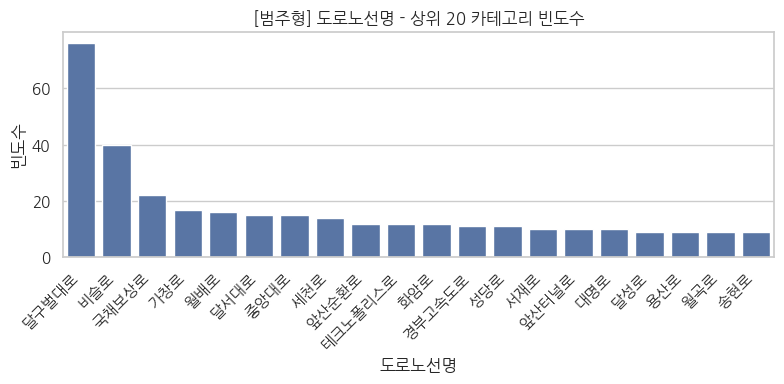

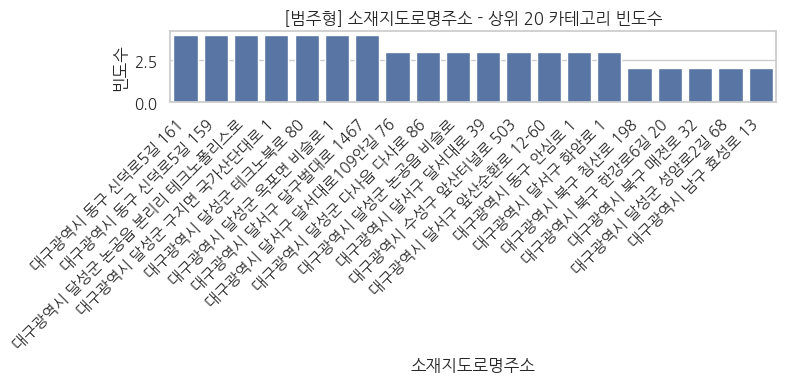

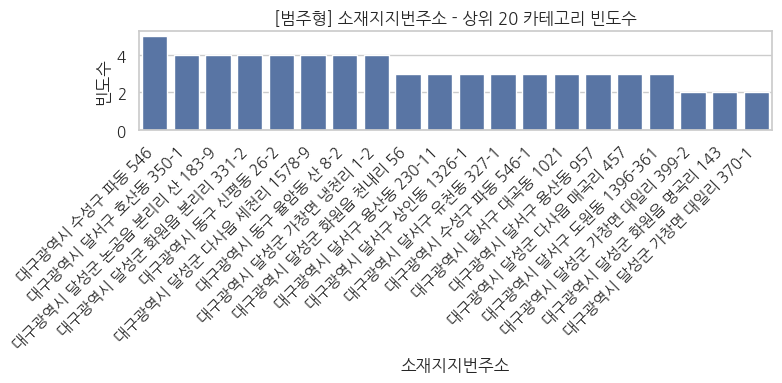

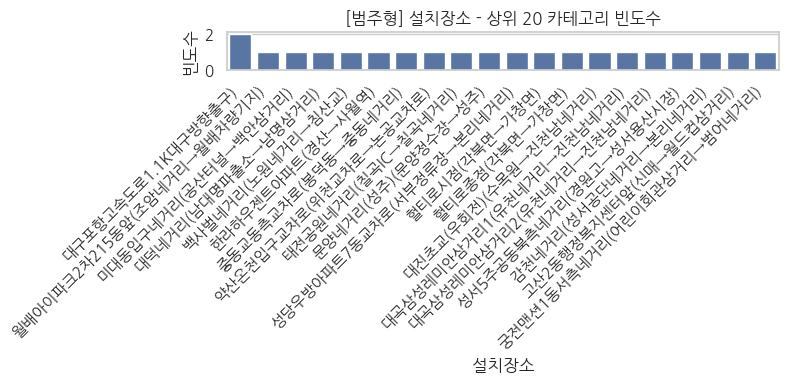

In [ ]:
# ==========================================
# 9. 모든 범주형 컬럼 bar chart
# ==========================================

TOP_N = 20  # 상위 몇 개 카테고리까지 시각화할지 설정

if len(categorical_cols) == 0:
    print("범주형 컬럼이 없어 bar chart를 그릴 수 없습니다.")
else:
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(TOP_N)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=value_counts.index.astype(str),
                    y=value_counts.values)
        plt.title(f"[범주형] {col} - 상위 {TOP_N} 카테고리 빈도수")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## 10. AI 화면 구현과 다른 점